# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [18]:
import numpy as np
from glob import glob
import os
import sys

from PIL import Image
import cv2    
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

In [31]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


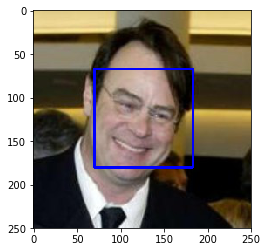

In [32]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [33]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [12]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

count_human_hf = 0
for hf in human_files_short:
    is_human = face_detector(hf)
    if is_human:
        count_human_hf+=1
print("Percentage of the first 100 images in human_files that have a detected human face is {}%.".format(count_human_hf))

count_human_df = 0
for df in dog_files_short:
    is_human= face_detector(df)
    if is_human:
        count_human_df+=1
print("Percentage of the first 100 images in dog_files that have a detected human face is {}%.".format(count_human_df))

Percentage of the first 100 images in human_files that have a detected human face is 98%.
Percentage of the first 100 images in dog_files that have a detected human face is 17%.


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [34]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 100405626.20it/s]


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [35]:
from PIL import Image
import torchvision.transforms as transforms

def process_image(img_path):
    ''' 
    Scales, crops, and normalizes a PIL image for a PyTorch model
        
    Args:
        img_path: path to an image
        
    Returns:
        Numpy array of image
    '''    
    # Open image as PIL image
    im = Image.open(img_path)
    
    # Get width and height of PIL image
    width, height = im.size
    # Calculate aspect ratio
    aspect_ratio = width/height
    # Make shortest side 256 pixels, keeping aspect ratio
    if width < height:
        im.resize((256,int(256*aspect_ratio**-1)))
    else:
        im.resize((int(256*aspect_ratio),256))

    # Center crop to 224 x 224 
    left = (width - 224)/2
    top = (height - 224)/2
    right = (width + 224)/2
    bottom = (height + 224)/2
    im = im.crop((left, top, right, bottom))
    
    # Convert PIL image to numpy array
    np_image = np.array(im)
    
    # Scale color channels to floats 0–1
    np_image_scaled = np.array(np_image)/255
    
    # Normalize image
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_norm_image = (np_image_scaled - mean)/std
    
    # Reorder dimensions so that color channel is first, retain order of other two
    np_final_image = np.transpose(np_norm_image, [2,0,1])
    
    return np_final_image

In [35]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    
    ## Load and pre-process an image from the given img_path
    img = process_image(img_path)
    
    ## Return the *index* of the predicted class for that image
    
    # Set model to evaluation mode
    VGG16.eval()
    
    # Convert numpy array image to tensor
    timg = torch.from_numpy(img).type(torch.FloatTensor)

    # Add batch of size 1 to image
    timg.unsqueeze_(0)

    # Use GPU if it's available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Calculate the class log probabilities for img
    with torch.no_grad():
        timg = timg.to(device)
        output = VGG16.forward(timg)
    
    # Calculate class probabilities for img
    ps = torch.exp(output)
    
    # Determine top probability and predicted index
    top_probs, top_indices = ps.topk(1, dim=1) 
    top_index = top_indices.cpu().detach().numpy().tolist()[0][0]
    
    return top_index # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [36]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        returns "True" if dog is detected in image stored at img_path
    '''
    index = VGG16_predict(img_path)
    
    return 151 <= index <= 268 # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [19]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

count_dog_hf = 0
for hf in human_files_short:
    is_dog = dog_detector(hf)
    if is_dog:
        count_dog_hf+=1
print("Percentage of the first 100 images in human_files that have a detected dog is {}%.".format(count_dog_hf))

count_dog_df = 0
for df in dog_files_short:
    is_dog= dog_detector(df)
    if is_dog:
        count_dog_df+=1
print("Percentage of the first 100 images in dog_files that have a detected dog is {}%.".format(count_dog_df))

Percentage of the first 100 images in human_files that have a detected dog is 1%.
Percentage of the first 100 images in dog_files that have a detected dog is 91%.


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [2]:
data_dir = 'dog_images'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
import os
import torch
from torchvision import datasets, transforms, models
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(45),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], 
                             [0.229, 0.224, 0.225])
    ]),
}

# TODO: Load the datasets with ImageFolder
dirs = {'train': train_dir, 
        'valid': valid_dir, 
        'test' : test_dir}

image_datasets = {x: datasets.ImageFolder(dirs[x], transform=data_transforms[x]) for x in ['train', 'valid', 'test']}

# TODO: Using the image datasets and the transforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True) for x in ['train', 'valid', 'test']}

# Get the number of images for each dataset
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}

In [4]:
print(dataset_sizes)

{'train': 6680, 'valid': 835, 'test': 836}


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

For the training dataset, the images were randomly cropped and resized to 224x224. The images for the validation and test datasets were first resized to 256x256 and then center cropped to 224x224. I chose 224x224 for the input tensor because the transfer learning model, densenet121, was trained on images of that size. 

The training dataset was augmented with a random horizontal flip and a random rotation of 45 degrees set as the max. In addition, a random resized crop was implemented.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer 
        self.fc1 = nn.Linear(64 * 28 * 28, 6272)
        # linear layer 
        self.fc2 = nn.Linear(6272, 133)
        # dropout layer
        self.dropout = nn.Dropout(0.25)
        
        # batch norm layers
        self.conv_bn1 = nn.BatchNorm2d(16)
        self.conv_bn2 = nn.BatchNorm2d(32)
        self.conv_bn3 = nn.BatchNorm2d(64)
    
    def forward(self, x):
        ## Define forward behavior
        # add sequence of convolutional, batch norm, and max pooling layers with relu activation
        x = self.pool(F.relu(self.conv1(x)))
        x = self.conv_bn1(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.conv_bn2(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.conv_bn3(x)
        # flatten image input
        x = x.view(-1, 64 * 28 * 28)
        # add dropout layer
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add output layer
        x = self.fc2(x)
        return x

#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    
print(model_scratch)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=6272, bias=True)
  (fc2): Linear(in_features=6272, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
  (conv_bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I wanted my final CNN architecture to have at least three convolutional layers. Any model with one or two layers may not be enough to effectively extract features important for classifying dog breeds. I then added max pooling, dropout, and batch normalization layers to my CNN architecture to reduce overfitting. Lastly, I attached two fully connected layers to my final model with the second layer serving as the final output layer.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [6]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [4]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    '''
    Trains a model
    
    Args:
        n_epochs: number of epochs
        loaders: dataloaders
        model
        optimizer
        criterion
        use_cuda
        save_path: filepath to final model parameters 
    
    Returns:
        Trained model
        
    '''
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)  
            ## update the validation loss
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))     
  
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
            
    # return trained model
    return model 

In [7]:
import time

# track time to train model
start_time = time.time()

# train the model
model_scratch = train(100, dataloaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

time_elapsed = time.time() - start_time
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 5.813239 	Validation Loss: 4.637502
Validation loss decreased (inf --> 4.637502).  Saving model ...
Epoch: 2 	Training Loss: 4.686732 	Validation Loss: 4.475077
Validation loss decreased (4.637502 --> 4.475077).  Saving model ...
Epoch: 3 	Training Loss: 4.611963 	Validation Loss: 4.405196
Validation loss decreased (4.475077 --> 4.405196).  Saving model ...
Epoch: 4 	Training Loss: 4.521450 	Validation Loss: 4.410087
Epoch: 5 	Training Loss: 4.466027 	Validation Loss: 4.273139
Validation loss decreased (4.405196 --> 4.273139).  Saving model ...
Epoch: 6 	Training Loss: 4.412416 	Validation Loss: 4.236303
Validation loss decreased (4.273139 --> 4.236303).  Saving model ...
Epoch: 7 	Training Loss: 4.364655 	Validation Loss: 4.257430
Epoch: 8 	Training Loss: 4.336683 	Validation Loss: 4.133564
Validation loss decreased (4.236303 --> 4.133564).  Saving model ...
Epoch: 9 	Training Loss: 4.268340 	Validation Loss: 3.967272
Validation loss decreased (4.133564 --> 3.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [4]:
def test(loaders, model, criterion, use_cuda):    
    '''
    Tests a model and prints out test loss and accuracy
    
    Args:
        loaders: dataloaders
        model
        optimizer
        criterion
        use_cuda       
    '''

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [10]:
# call test function    
test(dataloaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.241137


Test Accuracy: 24% (204/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [ ]:
## TODO: Specify data loaders
## Run cell above from previous step to get data loaders

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [37]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

# Load the pretrained model from pytorch
model_transfer = models.densenet121(pretrained=True)

# Freeze parameters
for param in model_transfer.parameters():
    param.requires_grad = False

/opt/conda/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:00<00:00, 87185325.34it/s]


In [38]:
n_inputs = model_transfer.classifier.in_features

last_layer = nn.Linear(n_inputs, 133)

model_transfer.classifier = last_layer

# check to see that your last layer produces the expected number of outputs
print(model_transfer.classifier.out_features)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

device = None

if use_cuda:
    model_transfer = model_transfer.cuda()
    device = 'cuda'
else:
    model_transfer = model_transfer.cpu()
    device = 'cpu'

133


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I chose to use the pretrained model, densenset121, for my final CNN architecture since I got good results when I used this model for a different project classifying images. The only modification I made was changing the last layer to produce the expected number of outputs (133). 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [9]:
import torch.optim as optim

criterion_transfer = nn.CrossEntropyLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer_transfer = optim.Adam(model_transfer.classifier.parameters(), lr=0.0003)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [9]:
# train the model
model_transfer = train(50, dataloaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Training Loss: 4.364928 	Validation Loss: 3.604203
Validation loss decreased (inf --> 3.604203).  Saving model ...
Epoch: 2 	Training Loss: 3.380899 	Validation Loss: 2.667418
Validation loss decreased (3.604203 --> 2.667418).  Saving model ...
Epoch: 3 	Training Loss: 2.709631 	Validation Loss: 2.097098
Validation loss decreased (2.667418 --> 2.097098).  Saving model ...
Epoch: 4 	Training Loss: 2.269399 	Validation Loss: 1.790347
Validation loss decreased (2.097098 --> 1.790347).  Saving model ...
Epoch: 5 	Training Loss: 1.964833 	Validation Loss: 1.420867
Validation loss decreased (1.790347 --> 1.420867).  Saving model ...
Epoch: 6 	Training Loss: 1.751480 	Validation Loss: 1.256734
Validation loss decreased (1.420867 --> 1.256734).  Saving model ...
Epoch: 7 	Training Loss: 1.610933 	Validation Loss: 1.081154
Validation loss decreased (1.256734 --> 1.081154).  Saving model ...
Epoch: 8 	Training Loss: 1.494796 	Validation Loss: 0.940366
Validation loss decreased (1.08115

In [39]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt', map_location = device))

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [10]:
test(dataloaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.414608


Test Accuracy: 87% (730/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [26]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in image_datasets['train'].classes]

In [27]:
# save class names
np.save('class_names.npy', class_names)

In [40]:
# load class names
class_names = np.load("class_names.npy")

In [41]:
def predict_breed_transfer(img_path, model, class_names, k=2):
    '''
    Load the image and return the predicted breed
    
    Args:
        img_path: path to image
        model
        class_names: list of class names 
        k: integer of classes to save
        
    Returns:
        top_probs: list of probabilities for each class 
        top_breeds: list of class names ~ breeds
    '''      
    # Set device to cpu or cuda
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # check if CUDA is available
    use_cuda = torch.cuda.is_available()

    if use_cuda:
        # Convert model to gpu
        model.cuda()        
    else:
        model.cpu()
        
    # Set model to evaluation mode
    model.eval()
    
    # Preprocess image
    img = process_image(img_path)
    
    # Convert numpy array image to tensor
    timg = torch.from_numpy(img).type(torch.FloatTensor)

    # Add batch of size 1 to image
    timg.unsqueeze_(0)

    # Calculate the class probabilities for img
    with torch.no_grad():
        timg = timg.to(device)
        output = model.forward(timg)
    
    # Convert probabilities to proper format 
    ps = nn.functional.softmax(output, dim=1)
    
    # Determine top probabilities and predicted classes 
    top_probs, top_indices = ps.topk(k, dim=1)
    top_probs = top_probs.cpu().detach().numpy().tolist()[0] 
    top_indices = top_indices.cpu().detach().numpy().tolist()[0]

    # Convert indices to classes
    #idx_to_class = {val: key for key, val in model.class_to_idx.items()}
    #top_classes = [idx_to_class[index] for index in top_indices]
    top_dog_breeds = [class_names[cat] for cat in top_indices]  
    
    return top_probs, top_dog_breeds

In [42]:
probs, breeds = predict_breed_transfer("dog_images/train/002.Afghan_hound/Afghan_hound_00081.jpg", model_transfer, class_names, k=2)

In [43]:
for prob, breed in zip(probs, breeds):
    print('{}: {:.3f}'.format(breed, prob))

Afghan hound: 0.570
Golden retriever: 0.090


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [52]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path, model):
    '''
    Accepts a file path to image, determines whether image contains a human, dog, or neither, and returns dog breed.
    
    Args:
        img_path: path to image
        model
    '''      
    # Check if image contains a human
    is_human = face_detector(img_path)
    # Check if image contains a dog
    is_dog = dog_detector(img_path)
    
    # Exit program if both human and dog are detected or neither is detected
    if (is_human and is_dog) or (not is_human and not is_dog):
        print("Error processing image. Please ensure your image contains either a human or a dog.")
        sys.exit()    
    
    # Predict dog breed
    probs, breeds = predict_breed_transfer(img_path, model, class_names, k=2)
    
    # Print out top breed for human image
    if is_human:
        print("Hello Human!")
        # load image
        img = mpimg.imread(img_path)
        # show image
        plt.imshow(img)
        plt.axis('off') 
        plt.show()
        print("You look like a ...")
        print(breeds[0].replace("_", " "))
    
    # Print out top breed for dog image
    if is_dog:
        print("Hello Dog!")
        # load image
        img = mpimg.imread(img_path)
        # show image        
        plt.imshow(img)
        plt.axis('off') 
        plt.show()
        print("Your predicted breed is ...")
        # Check if top second breed's probability is within 10% of top breed's probability 
        if probs[1] >= (probs[0]-probs[0]*0.1):
            # print out both breeds
            print("Mixed breed: {} and {}".format(breeds[0].replace("_", " "), breeds[1].replace("_", " ")))
        else:
            # print out the top breed
            print(breeds[0].replace("_", " ")) 

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

Even though I got 87% accuracy on the test dataset, the output could be better. As expected, the algorithm doesn't do well with classifying dog breeds with minimal inter-class variation or high intra-class variation. In addition, the algorithm fails to identify the correct dog breeds in mutts. Instead, the algorithm tends to output the dog breed that matches closely with the image dog's coat color and patterns. 

Three possible points of improvement:

1. Improve the human detector. Around 17% of the dog images were misclassified as human.
2. Improve the dog detector. Around 9% of the dog images were not classified as dog. 
3. Improve the classifier. The current model achieved 87% test accuracy. 

Hello Human!


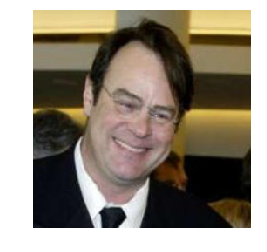

You look like a ...
English springer spaniel


Hello Human!


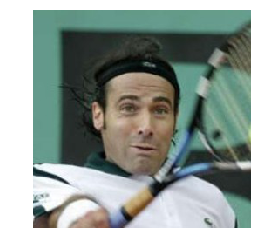

You look like a ...
Dachshund


Hello Human!


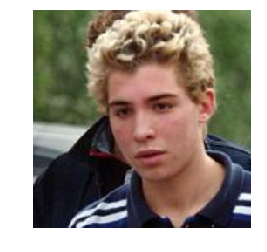

You look like a ...
American water spaniel


Hello Dog!


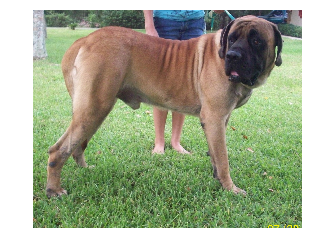

Your predicted breed is ...
Mixed breed: Dogue de bordeaux and Mastiff


Hello Dog!


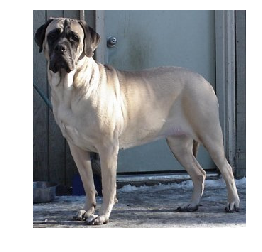

Your predicted breed is ...
Mastiff


Hello Dog!


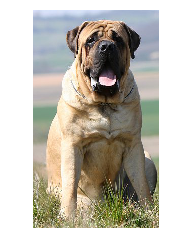

Your predicted breed is ...
Mastiff




In [55]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file, model_transfer)
    print("\n")

Hello Human!


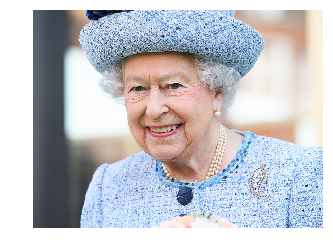

You look like a ...
Bull terrier


In [57]:
run_app("sample_images/queen-elizabeth.jpg", model_transfer)

Hello Human!


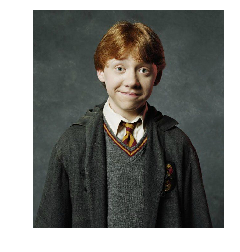

You look like a ...
Chihuahua


In [58]:
run_app("sample_images/Ronweasley.jpg", model_transfer)

Hello Human!


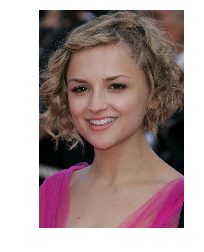

You look like a ...
Chihuahua


In [74]:
run_app("sample_images/rachael-leigh-cook.jpg", model_transfer)

Hello Dog!


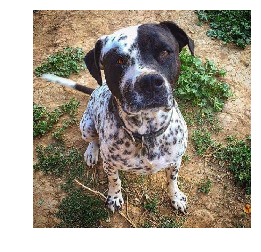

Your predicted breed is ...
Pointer


In [59]:
# Mixed breed of bull dog and dalmation - bullmation
run_app("sample_images/bullmation.jpg", model_transfer)

In [64]:
# Top 3 classes for bullmation
probs, breeds = predict_breed_transfer("sample_images/bullmation.jpg", model_transfer, class_names, k=3)
for prob, breed in zip(probs, breeds):
    print('{}: {:.3f}'.format(breed, prob))

Pointer: 0.158
English cocker spaniel: 0.098
Dalmatian: 0.093


Hello Dog!


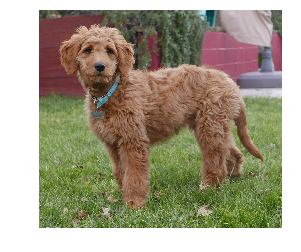

Your predicted breed is ...
Otterhound


In [65]:
# Mixed breed of golden retriever and poodle - golden doodle
run_app("sample_images/Golden_Doodle.jpg", model_transfer)

In [66]:
# Top 3 classes for golden doodle
probs, breeds = predict_breed_transfer("sample_images/Golden_Doodle.jpg", model_transfer, class_names, k=3)
for prob, breed in zip(probs, breeds):
    print('{}: {:.3f}'.format(breed, prob))

Otterhound: 0.170
Briard: 0.149
Norwich terrier: 0.109


Hello Dog!


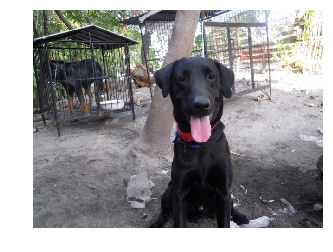

Your predicted breed is ...
Labrador retriever


In [69]:
run_app("images/Labrador_retriever_06449.jpg", model_transfer)

Hello Dog!


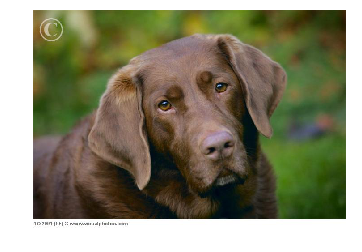

Your predicted breed is ...
Chesapeake bay retriever


In [70]:
run_app("images/Labrador_retriever_06455.jpg", model_transfer)

Hello Dog!


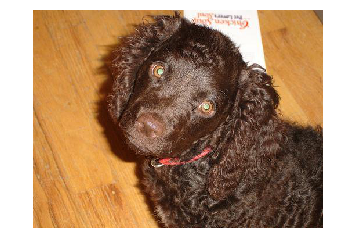

Your predicted breed is ...
Boykin spaniel


In [71]:
run_app("images/American_water_spaniel_00648.jpg", model_transfer)

Hello Dog!


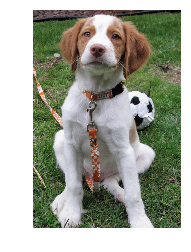

Your predicted breed is ...
Parson russell terrier


In [73]:
run_app("images/Brittany_02625.jpg", model_transfer)

In [1]:
# Convert notebook to html
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook dog_app-cn.ipynb to html',
 '[NbConvertApp] Writing 332820 bytes to dog_app-cn.html',
 '[NbConvertApp] Converting notebook dog_app.ipynb to html',
 '[NbConvertApp] Writing 2624708 bytes to dog_app.html']